# PCA with SciKit Learn

```yaml
Course:   DS 5001
Module:   07 Lab
Topic:    PCA
Author:   R.C. Alvarado
Date:     27 Februrary 2024 (revised)
```

**Purpose:**  To implement PCA with SciKit Learn and explore application to Austen-Melville corpus.

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm

In [2]:
import plotly_express as px
import seaborn as sns

In [3]:
sns.set(style='ticks')

## Config

In [4]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
# data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
# local_lib = config['DEFAULT']['local_lib']

In [5]:
data_prefix = 'austen-melville'

In [6]:
OHCO = ['book_id', 'chap_id']

In [7]:
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False

We pick a color map for our gradient visualizations. For more info on color maps, see the [Matplotlib docs](https://matplotlib.org/stable/tutorials/colors/colormaps.html) on the subject.

In [8]:
colors = "YlGnBu" 
# colors = "Spectral"

# Prepare the Data

## Import tables

In [9]:
LIB = pd.read_csv(f'{output_dir}/{data_prefix}-LIB_LABELS.csv').set_index('book_id')
TFIDF = pd.read_csv(f'{output_dir}/{data_prefix}-TFIDF_chap_L2.csv').set_index(['book_id', 'chap_id'])

In [10]:
TFIDF

sure     hands     short       new      word    passed  \
book_id chap_id                                                               
105     1       -0.012271  0.003859 -0.007822  0.016705  0.004818  0.004608   
        2       -0.012271  0.007178  0.024156 -0.009181  0.008190 -0.007954   
        3        0.014675  0.004502  0.005497 -0.009181  0.005471 -0.007954   
        4       -0.012271 -0.008847  0.041215 -0.009181  0.008554 -0.007954   
        5        0.026462  0.003946 -0.007822  0.016880  0.017906 -0.007954   
...                   ...       ...       ...       ...       ...       ...   
34970   110     -0.012271 -0.008847 -0.007822 -0.009181 -0.008095 -0.007954   
        111     -0.012271  0.030472 -0.007822 -0.009181  0.011884  0.069787   
        112     -0.012271  0.048792 -0.007822 -0.009181 -0.008095  0.020537   
        113     -0.012271 -0.008847 -0.007822 -0.009181 -0.008095 -0.007954   
        114     -0.012271  0.017075 -0.007822 -0.009181 -0.008095 -0.007954   

                     fine      name     given     sight  ...    dreamy  \
book_id chap_id                                          ...             
105     1        0.004317  0.017191  0.044287 -0.007747  ... -0.001295   
        2       -0.008626 -0.008281  0.008758 -0.007747  ... -0.001295   
        3       -0.008626  0.085380  0.006026  0.005756  ... -0.001295   
        4        0.008062  0.008140  0.025849 -0.007747  ... -0.001295   
        5        0.004405 -0.008281  0.005458 -0.007747  ... -0.001295   
...                   ...       ...       ...       ...  ...       ...   
34970   110     -0.008626 -0.008281 -0.007602  0.017224  ... -0.001295   
        111     -0.008626 -0.008281  0.012468 -0.007747  ... -0.001295   
        112     -0.008626  0.020605 -0.007602 -0.007747  ... -0.001295   
        113     -0.008626 -0.008281 -0.007602 -0.007747  ... -0.001295   
        114     -0.008626 -0.008281 -0.007602  0.018475  ... -0.001295   

                     lash  delayed  outrageous  congregation      haul  \
book_id chap_id                                                          
105     1       -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        2       -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        3       -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        4       -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        5       -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
...                   ...      ...         ...           ...       ...   
34970   110     -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        111     -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        112     -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        113     -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   
        114     -0.001565 -0.00101   -0.001003     -0.001498 -0.001491   

                 promoted    offend     irons  uncertainty  
book_id chap_id                                             
105     1        0.046909 -0.000955 -0.001315    -0.000986  
        2       -0.001148 -0.000955 -0.001315    -0.000986  
        3       -0.001148 -0.000955 -0.001315    -0.000986  
        4       -0.001148 -0.000955 -0.001315    -0.000986  
        5       -0.001148  0.046889 -0.001315    -0.000986  
...                   ...       ...       ...          ...  
34970   110     -0.001148 -0.000955 -0.001315    -0.000986  
        111     -0.001148 -0.000955 -0.001315    -0.000986  
        112     -0.001148 -0.000955 -0.001315    -0.000986  
        113     -0.001148 -0.000955 -0.001315    -0.000986  
        114     -0.001148 -0.000955 -0.001315    -0.000986  

[1182 rows x 5000 columns]

# Run PCA

In [11]:
pca_engine = PCA(n_components=10)

In [12]:
DCM = pd.DataFrame(pca_engine.fit_transform(TFIDF.fillna(0)), index=TFIDF.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','label']], on='book_id')

In [15]:
def vis_pcs(M, a, b, label='author', hover_name='label', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

In [16]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VSHORT)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos_group', 
                      marginal_x='box', height=800)

## PC 0 and 1

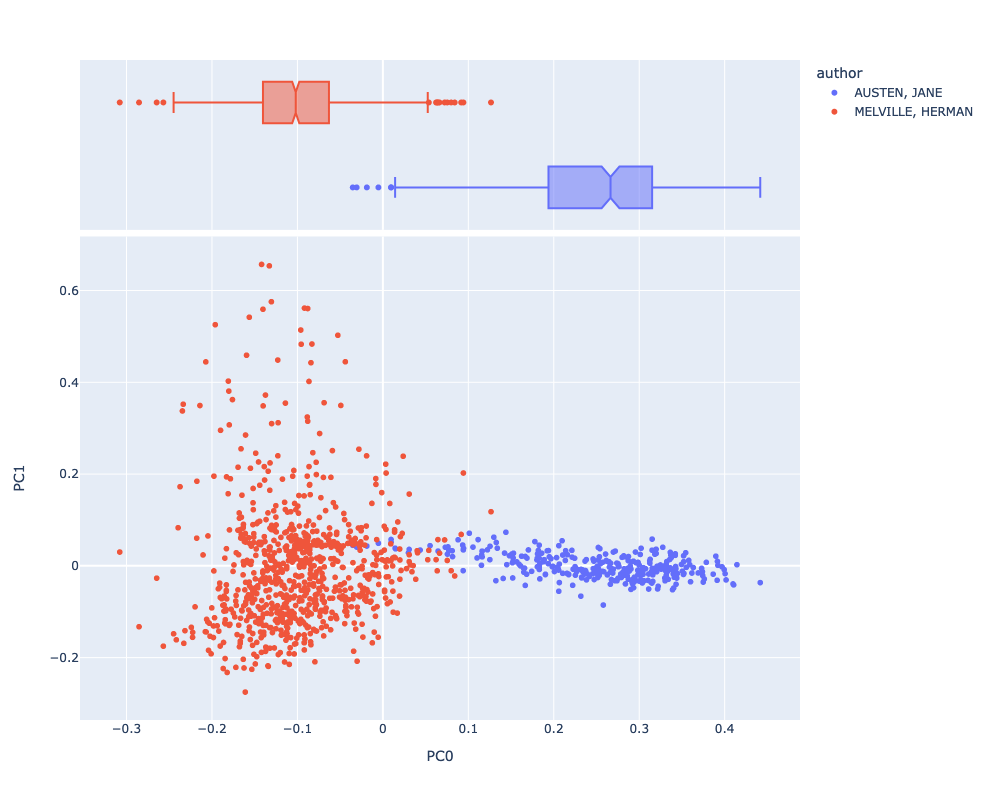

In [17]:
vis_pcs(DCM, 0, 1)

## PC 1 and 2

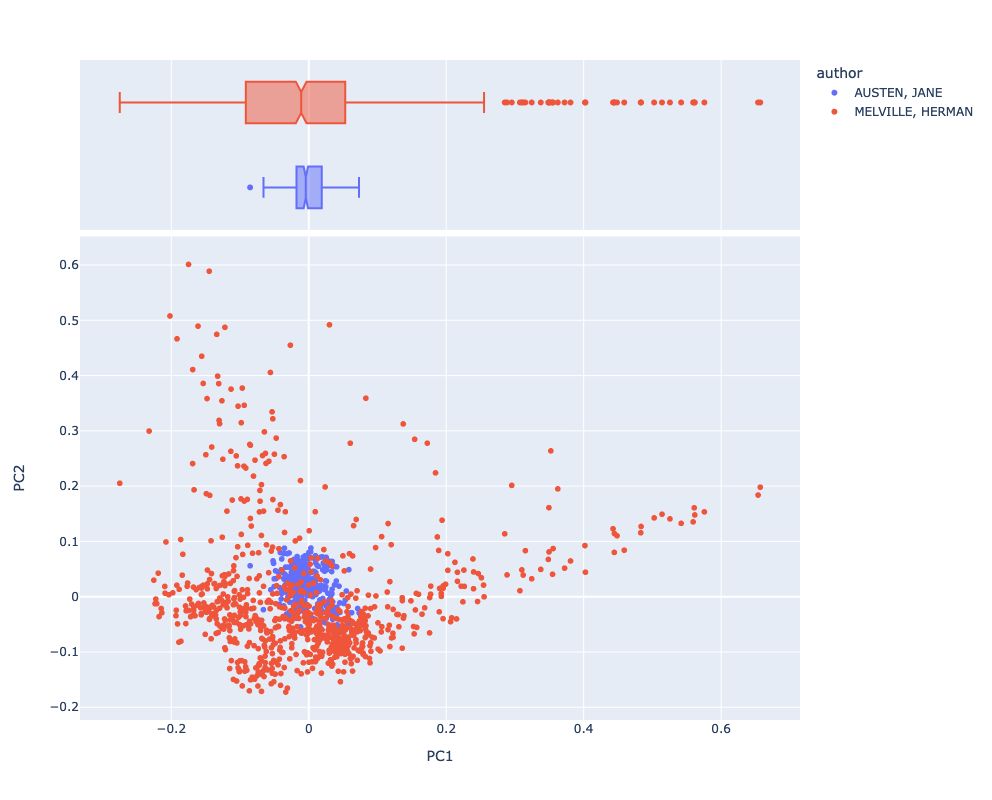

In [29]:
vis_pcs(DCM, 1, 2)

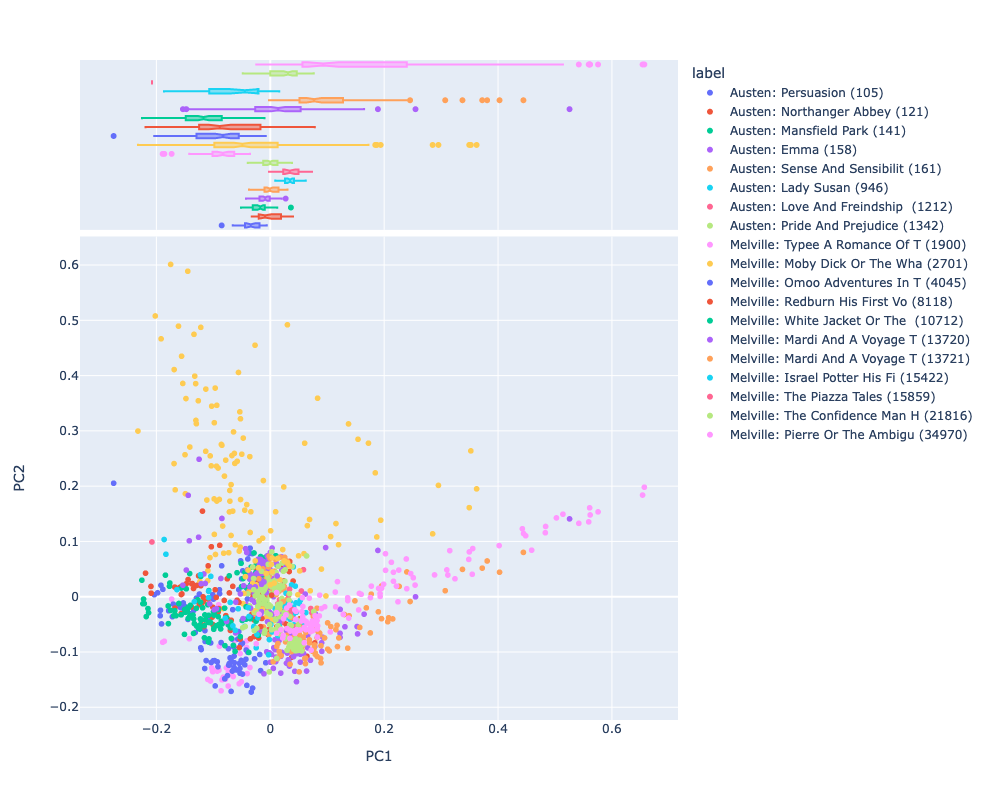

In [28]:
vis_pcs(DCM, 1, 2, label='label')

##  PC 2 and 3

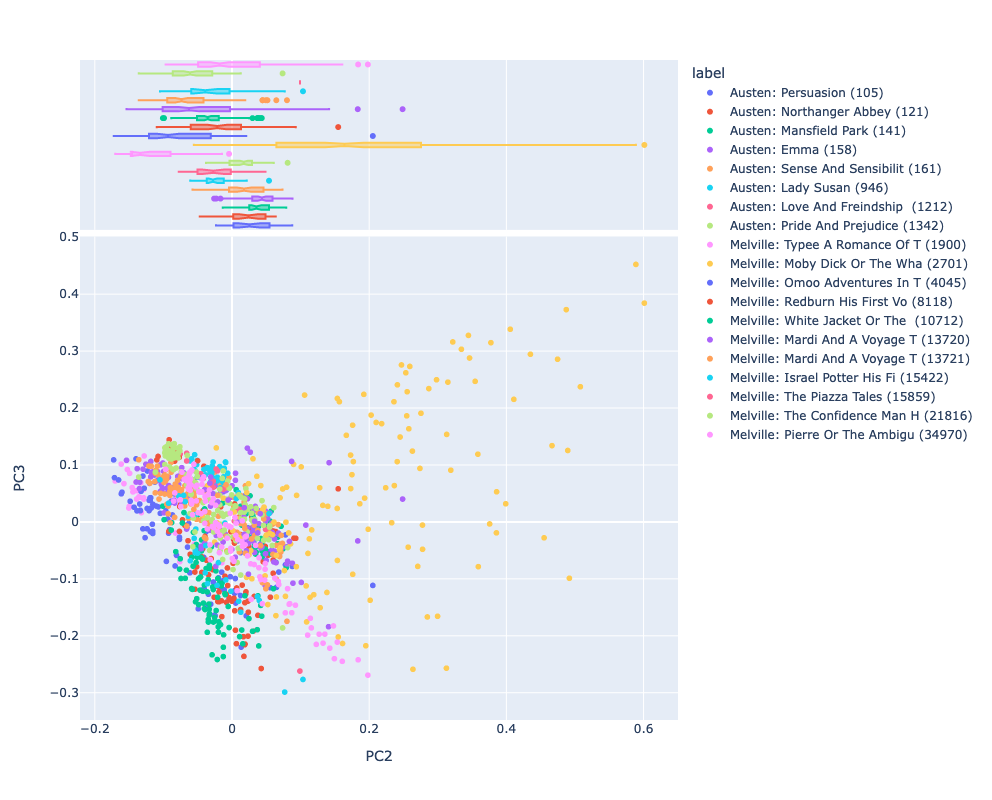

In [30]:
vis_pcs(DCM, 2, 3, label='label')

## Get Loadings

In [39]:
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = TFIDF.columns
LOADINGS.index.name = 'term_str'

In [40]:
top_terms_sk= {}
data = []
for i in range(10):
    for j in [0, 1]:
        data.append((i, j, ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())))

In [41]:
comp_strs = pd.DataFrame(data)
comp_strs.columns =  ['pc', 'pole', 'gloss']
comp_strs = comp_strs.set_index(['pc', 'pole'])

In [42]:
comp_strs.unstack()

gloss  \
pole                                                  0   
pc                                                        
0     am sister dear think letter had mother do wish...   
1       thou thee thy hath art oh hast brother ye thine   
2     whale whales thou thee boat ye boats ship thy ...   
3     whale whales fish valley oil acquaintance tail...   
4     valley natives islanders island thou fruit tre...   
5         lord said ye dont cried wine ha beard yes old   
6     doctor dont ye confidence cabin consul door ge...   
7     boat sea sail canoe ye reef breeze sails land ...   
8     portrait mother soul book bed seemed room fath...   
9     doctor confidence boat ye letter dont nature c...   

                                                         
pole                                                  1  
pc                                                       
0      whale thou sea ship ye deck thee boat thy whales  
1     whale ship deck sailors boat mate sea ships wa...  
2     valley natives doctor island islanders canoe l...  
3     thou thee deck thy ship sailors mate jacket ye...  
4     war deck jacket officers gun top sailors friga...  
5     thee thou natives thy mother valley daughter d...  
6     lord war officers beard american frigate kings...  
7     whale book war american confidence doctor port...  
8     doctor thou natives lord thee ye island consul...  
9     room dance ladies acquaintance jacket whale pa...

# Interpretation

PC0: (+) Melville vs (-) Austen

PC1: (+) Melville Mardi and Pierre vs (-) Rest of Melville

PC2: (+) Melvile Moby vs (-) Rest of Melville